![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

**Aluno: Marcelo Aires**

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

%reload_ext watermark
%watermark -iv -v -p sklearn

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

sklearn: 1.3.0

pandas    : 2.0.3
matplotlib: 3.7.2
seaborn   : 0.12.2
numpy     : 1.24.3



In [2]:
filename_features = "./Dados/UCI HAR Dataset/features.txt"
filename_labels = "./Dados/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "./Dados/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "./Dados/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "./Dados/UCI HAR Dataset/train/y_train.txt"

filename_subtest = "./Dados/UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest = "./Dados/UCI HAR Dataset/test/X_test.txt"
filename_ytest = "./Dados/UCI HAR Dataset/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#")
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.nome_var)
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.nome_var)
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

**RESPOSTA:** Sem padronização chegamos em um número de componentes menor (**34 componentes**), porém a variancia total explicada foi de apenas 50. Enquanto com a padronização, tivemos um número de componentes maior (**63 componentes**), e a variancia total explicada foi de 505.<br> **Escolheria 63 componentes, pois são dados com unidades diferentes, e é de suma importância essa padronização para um resultado satisfatório.**

In [3]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = X_train.apply(padroniza, axis=0)
print(f"TRAIN SHAPE: {X_train_pad.shape}")

X_test_pad = X_test.apply(padroniza, axis=0)
print(f"TEST SHAPE: {X_test_pad.shape}\n")

TRAIN SHAPE: (7352, 561)
TEST SHAPE: (2947, 561)

CPU times: total: 172 ms
Wall time: 386 ms


In [4]:
def screeplot(princomp, ncomp = 0, varexplicada=0, criterio=1):
    
    if ncomp>0:
        ncomp_crit=ncomp
    elif varexplicada > 0:
        ncomp_crit = (princomp.explained_variance_ratio_.cumsum()<varexplicada).sum()+1 
        # Critério 1: autovalor padronizado > 1
    elif criterio == 1:
        ncomp_crit = (princomp.explained_variance_ratio_>1/princomp.n_components_).sum()
    else: ncomp_crit = None
    
    fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
    plt.subplots_adjust(hspace=0, wspace=.15)


    num_componentes = np.arange(princomp.n_components_) + 1
    ax[0,0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[0,0].set_title('Scree Plot - Variância total')
    ax[0,0].set_xlabel('Número de componentes')
    ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

    ax[1,0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[1,0].set_xlabel('Número de componentes')
    ax[1,0].set_ylabel('Variancia explicada (Acumulada)')


    ax[0,1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[0,1].set_title('Scree Plot - Variância percentual')
    ax[0,1].set_xlabel('Número de componentes')
    ax[0,1].set_ylabel('Variancia explicada (percentual)')

    ax[1,1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
    ax[1,1].set_xlabel('Número de componentes')
    ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')
    
    if ncomp_crit != None:
        # Linhas verticais de referência
        ax[0,0].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[1,1].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[1,0].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[0,1].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)


        # linhas horizontais
        variancia               = princomp.explained_variance_[ncomp_crit-1]
        variancia_acumulada     = princomp.explained_variance_.cumsum()[ncomp_crit-1]
        pct_variancia           = princomp.explained_variance_ratio_[ncomp_crit-1]
        pct_variancia_acumulada = princomp.explained_variance_ratio_.cumsum()[ncomp_crit-1]
        
        ax[0,0].axhline(y = variancia              , color = 'r', linestyle = '-', linewidth=.5)
        ax[1,0].axhline(y = variancia_acumulada    , color = 'r', linestyle = '-', linewidth=.5)
        ax[0,1].axhline(y = pct_variancia          , color = 'r', linestyle = '-', linewidth=.5)
        ax[1,1].axhline(y = pct_variancia_acumulada, color = 'r', linestyle = '-', linewidth=.5)


    print(f'Número de componentes:............... {ncomp_crit}')
    print(f'Variância da ultima CP:.............. {variancia:.2f}' )
    print(f'Variância total explicada:........... {variancia_acumulada:.2f}' )
    print(f'Variância percentual da última CP:... {100*pct_variancia:.2f}%' )
    print(f'Variância percentual total explicada: {100*pct_variancia_acumulada:.2f}%' )
    plt.show()
    return ncomp_crit

## SEM PADRONIZAÇÃO:

Número de componentes:............... 34
Variância da ultima CP:.............. 0.13
Variância total explicada:........... 50.15
Variância percentual da última CP:... 0.24%
Variância percentual total explicada: 90.09%


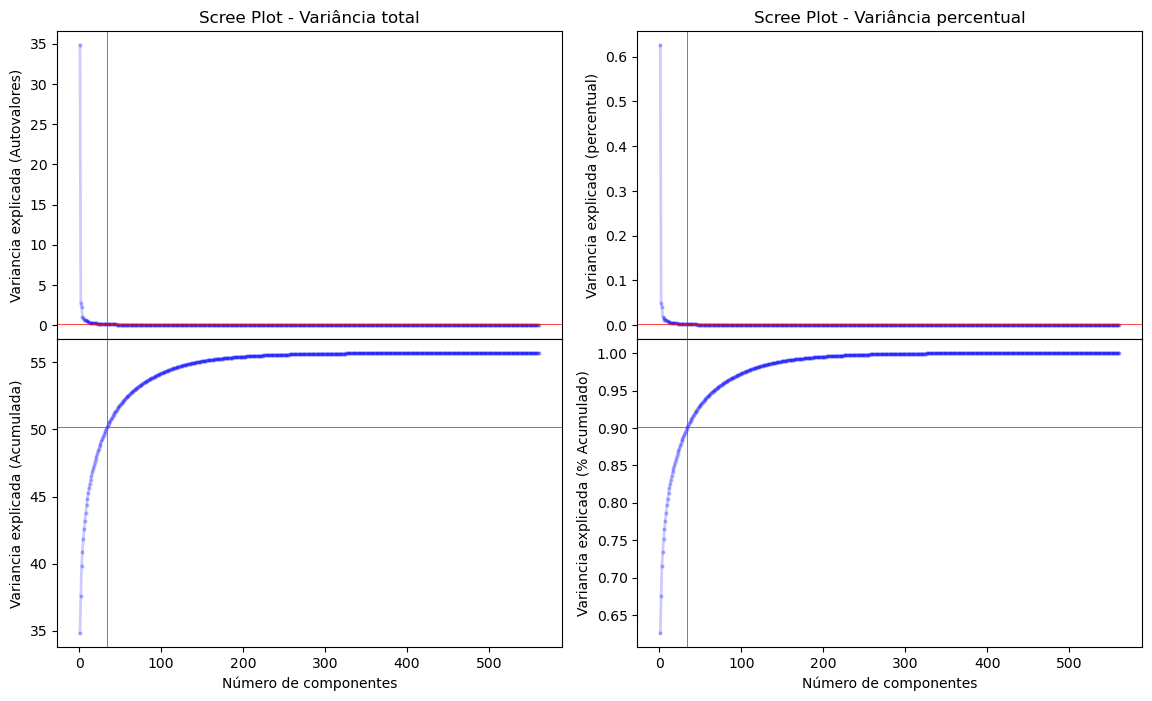

In [5]:
prcomp_sem = PCA().fit(X_train)
ncomp_sem = screeplot(prcomp_sem, varexplicada=.9)

## COM PADRONIZAÇÃO:

Número de componentes:............... 63
Variância da ultima CP:.............. 0.99
Variância total explicada:........... 505.20
Variância percentual da última CP:... 0.18%
Variância percentual total explicada: 90.05%


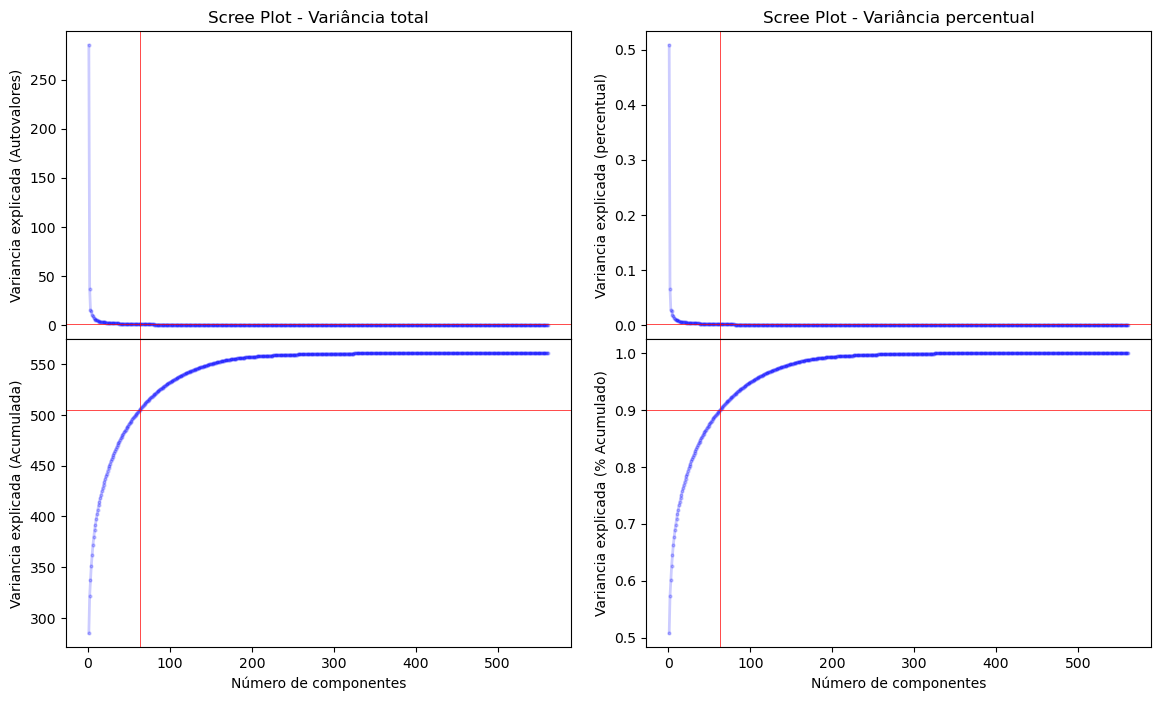

In [6]:
prcomp_com = PCA().fit(X_train_pad)
ncomp_com = screeplot(prcomp_com, varexplicada=.9)

## Árvore com PCA

Faça duas árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

**REPOSTA:**

**SEM PADRONIZAÇÃO:**<br>
**Acurácia Train: 89.24%, Acurácia Test: 82.42%**

**COM PADRONIZAÇÃO:**<br>
**Acurácia Train: 85.87%, Acurácia Test: 77.64%**

Sem a Padronização, a acurácia foi melhor, porém consideramos apenas 10 componentes. Devemos analisar qual é o melhor número de componetes e também se realmente é necessário a padronização dos dados, isso varia de caso pra caso.

## SEM PADRONIZAÇÃO:

In [7]:
n=10
prcomp_sem = PCA(n_components=n).fit(X_train)
colunas_sem = ['cp'+str(x+1) for x in list(range(n))]

pc_train_sem = pd.DataFrame(prcomp_sem.transform(X_train), columns=colunas_sem)
pc_test_sem = pd.DataFrame(prcomp_sem.transform(X_test), columns=colunas_sem)

pc_train_sem.head()

,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8,cp9,cp10
0,-5.520280,-0.290278,-1.529929,1.333240,1.425088,-0.194649,0.577377,0.691366,-1.222305,-0.362912
1,-5.535350,-0.082530,-1.924804,0.671272,0.671261,0.735152,-0.616965,-0.771720,-0.615312,-0.895346
2,-5.474988,0.287387,-2.144642,0.531804,0.207825,-0.037743,0.057503,0.093883,-0.062684,-0.216122
3,-5.677232,0.897031,-2.018220,0.157125,0.759085,1.079539,-0.267814,-0.731362,0.281182,0.466215
4,-5.748749,1.162952,-2.139533,0.207825,0.473092,0.462957,-0.152163,-0.107405,0.289313,0.538784


In [8]:
%%time

clf_sem = DecisionTreeClassifier(ccp_alpha=0.001, random_state=123)
clf_sem.fit(pc_train_sem, y_train)

pctrain_score_sem = clf_sem.score(pc_train_sem,y_train)
pctest_score_sem = clf_sem.score(pc_test_sem, y_test)

print(f"Acurácia Train: {round(pctrain_score_sem*100,2)}%")
print(f"Acurácia Test: {round(pctest_score_sem*100,2)}%\n")

Acurácia Train: 89.32%
Acurácia Test: 82.32%

CPU times: total: 734 ms
Wall time: 205 ms


## COM PADRONIZAÇÃO:

In [9]:
n=10
prcomp_com = PCA(n_components=n).fit(X_train_pad)
colunas_com = ['cp'+str(x+1) for x in list(range(n))]

pc_train_com = pd.DataFrame(prcomp_com.transform(X_train_pad), columns=colunas_com)
pc_test_com = pd.DataFrame(prcomp_com.transform(X_test_pad), columns=colunas_com)

pc_train_com.head()

,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8,cp9,cp10
0,-16.137446,2.151878,3.144569,-0.272455,6.798497,-4.249081,2.937107,-4.905111,-0.746811,-3.608281
1,-15.295154,1.387049,-0.682173,2.813480,4.265923,-2.055509,0.011712,-1.845798,0.500552,-0.148644
2,-15.135989,2.473183,-1.756521,3.717719,4.181295,-1.357429,0.072979,-1.387894,0.543608,-0.659096
3,-15.349840,3.915414,-1.790199,2.567342,3.205611,-0.942876,0.530623,-1.831071,1.083254,-1.479579
4,-15.543756,4.598424,-2.188432,2.897378,3.079936,-1.061386,-1.048247,-0.818141,0.606188,1.145984


In [10]:
%%time

clf_com = DecisionTreeClassifier(ccp_alpha=0.001, random_state=123)
clf_com.fit(pc_train_com, y_train)

pctrain_score_com = clf_com.score(pc_train_com, y_train)
pctest_score_com = clf_com.score(pc_test_com, y_test)

print(f"Acurácia Train: {round(pctrain_score_com*100,2)}%")
print(f"Acurácia Test: {round(pctest_score_com*100,2)}%\n")

Acurácia Train: 85.98%
Acurácia Test: 77.84%

CPU times: total: 484 ms
Wall time: 192 ms
